## Lecture 6: Tying up DP and intro to HMMs

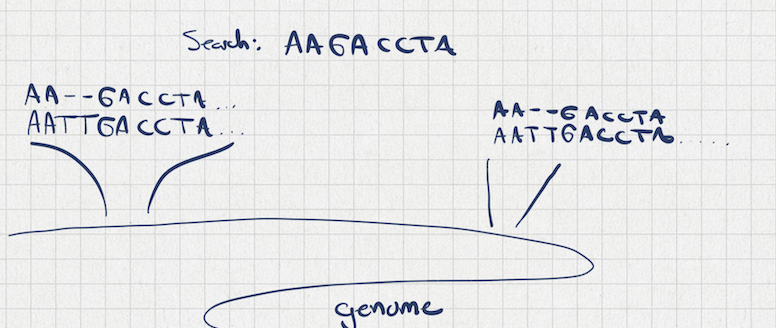
### 2021/05/24

#### Gene 111

## Logistics 

- Homework 5 due Wednesday

- Homework 4 is being graded

- Homework 6, our last homework, will be out on Wednesday. Due Monday.


## Dynamic programming wrap up 

- The scoring scheme is a really unsatisfying aspect of assigment 4

- mechanistically how different are these two sequence changes:



In [22]:
# ours scores:
match_score = 5
mismatch_score = -4
gap_score = -10

reference_seq = "ACTGACGTACGT"
sequence_A    = "A--GACGTA--T"
sequence_B    = "ACT-------GT"
sequence_C    = "ACTG----ACGT"

## Scoring these alignments

In [23]:

def score_alignment(reference,sequence):
    assert(len(reference) == len(sequence))
    score = 0
    for a,b in zip(reference,sequence):
        if a == '-' or b == '-':
            score += gap_score
        elif a != b:
            score += mismatch_score
        else:
            score += match_score
    return score

print(score_alignment(reference_seq,sequence_A))
print(score_alignment(reference_seq,sequence_B))
print(score_alignment(reference_seq,sequence_C))

0
-45
0


## This scoring scheme has a pretty simple model


$
score(i,j) = \max
\begin{cases} 
      score(i-1,j-1) + \text{our match or mismatch score} \\
      score(i-1,j) + \textbf{gap cost} \\
      score(i,j -1) + \textbf{gap cost} \\
   \end{cases}
$

Gaps are scored by simply multiplying their length by a cost value. Gaps of length 20 are the same as two gaps of length 10 (like the example above). This seems unfair to the biology...

## A better model 

$
score(i,j) = \max
\begin{cases} 
      score(i-1,j-1) + \text{our match or mismatch score} \\
      score(i-1,j) + \textbf{y(i - k)} \text{ for k = 0 to i -1}\\
      score(i,j -1) + \textbf{y(j - k)} \text{ for k = 0 to j -1}\\
   \end{cases}
   \\
$

- Here we look back at every possible position on the row or column 
- Find any gaps that maximize the function $y()$ 


## Convex alignment scoring

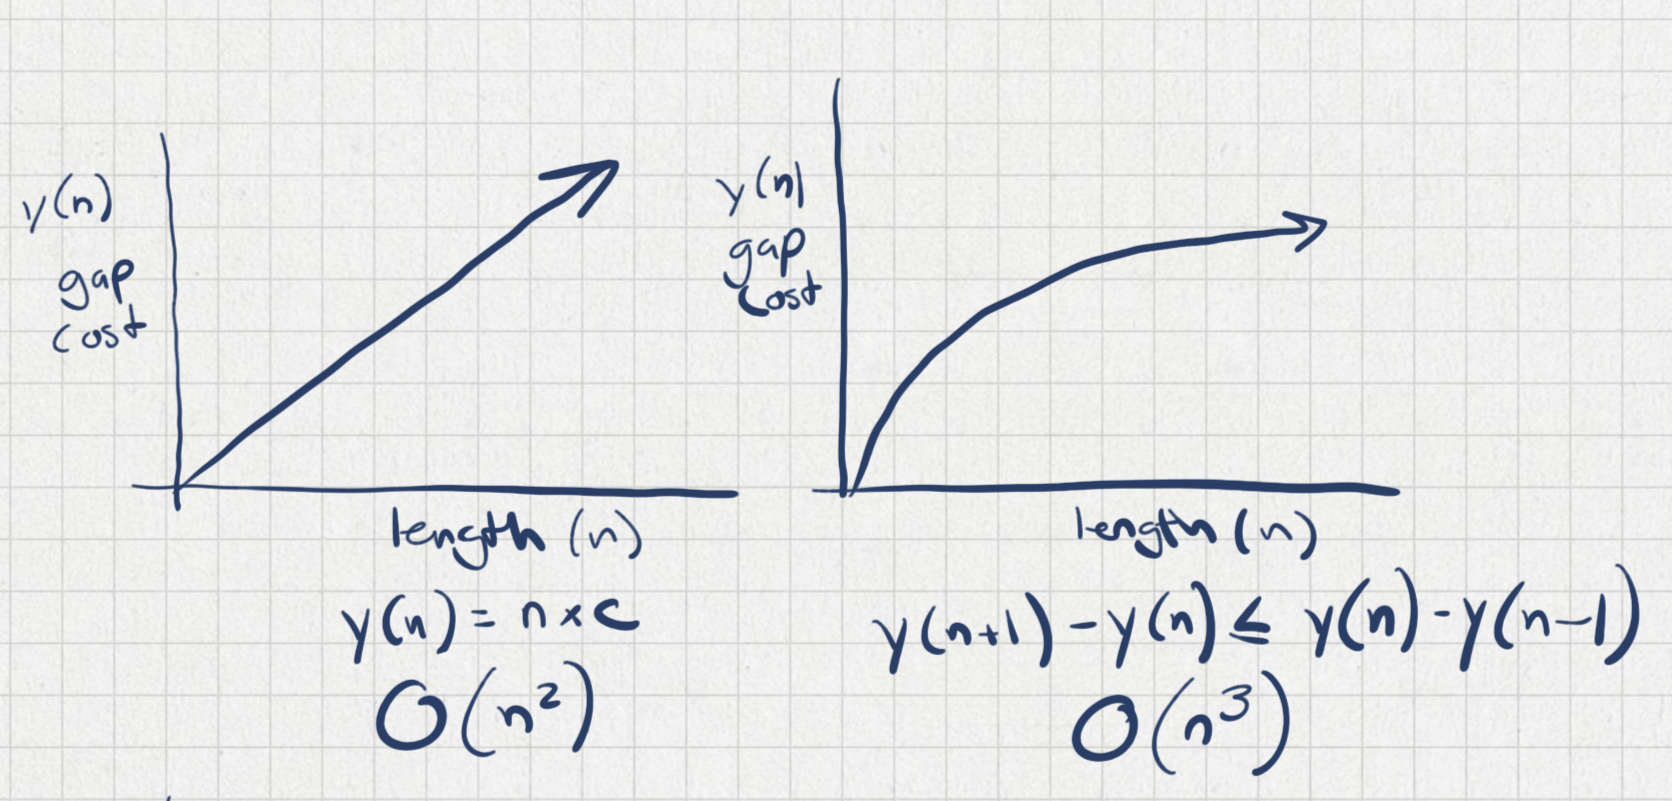

- How does this help? What can the function $y$ do for us?
- We can now score insertions more _'biologically'_
- Unfortuntely this is $O(n^3)$ in computational complexity. This makes it really hard to use in practice ($100^2$ vs $100^3$)
- The required space is still a $n*m$ matrix


## This one simple trick can save us!

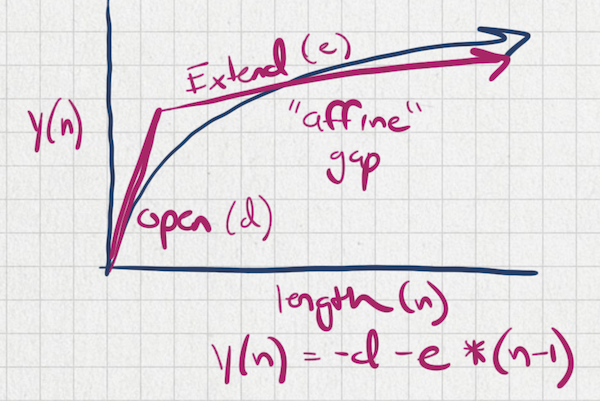

- We break this convex gap score into a two-part approximation
- Open a gap costs d, extending that gap costs only e (e < d)
- Still convex, though only a good approximation over a more narrow range of values
- Well how did this really save us?

## Scoring function now the transitions between three scoring tables

We now keep track of transistions between match and two insertion (or deletion) matrices:



$
\\
match(i,j) = \max
\begin{cases} 
    match(i-1,j-1) + \text{our match or mismatch score} \\
    insert_A(i-1,j-1) + \text{our match or mismatch score} \\
    insert_B(i-1,j-1) + \text{our match or mismatch score} \\
\end{cases}
   \\
insert_A(i,j) = \max
\begin{cases} 
    match(i-1,j) - \text{ gap open } d \\
    insert_A(i-1,j) - \text{ gap extend } e \\
\end{cases}
   \\
insert_B(i,j) = \max
\begin{cases} 
    match(i,j-1) - \text{ gap open } d \\
    insert_B(i,j-1) - \text{ gap extend } e \\
\end{cases}
\\
$

## I think it's easier to understand as a finite state machine

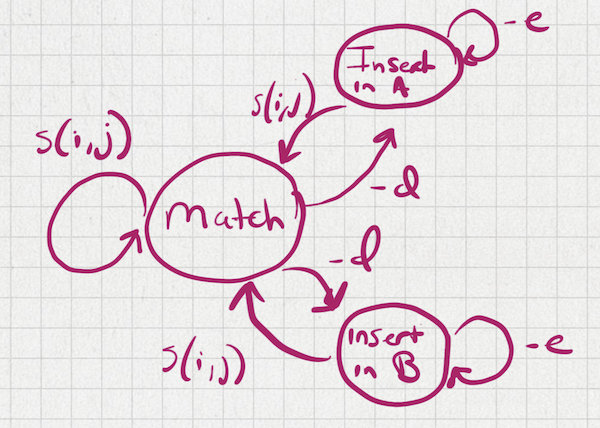

## We can transition between these states/matrices as we align the sequences

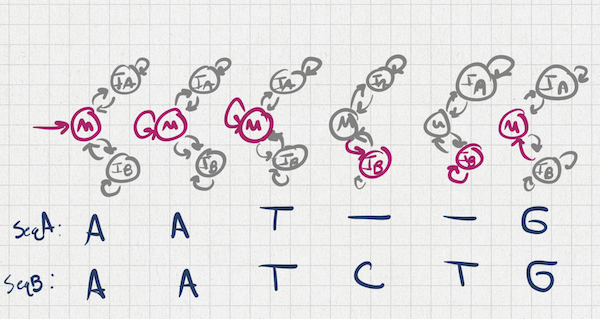

# Now imagine a scoring matrix at each node

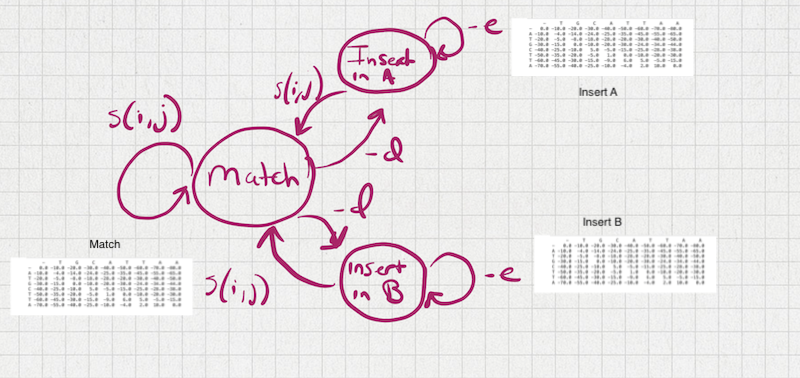

How do we do traceback?

## The end of our time with sequence alignment 

- Dynamic programming offers a fast approach for finding optimal solutions to sequence alignment

- Runtime in $O(nm)$ and space $n * m$ 

- Affine scoring schemes keep this $O(nm)$ complexity by again trading space ($3 * (n * m)$) for speed while providing more realistic gap models

- Profile hidden Markov models (HMMs), not covered here, incorporate probabilties into alignments 

## On to Markov models and hidden Markov models

- We've spent a lot of time talking about scoring schemes
- We've assumed they're universal but can we assume that?

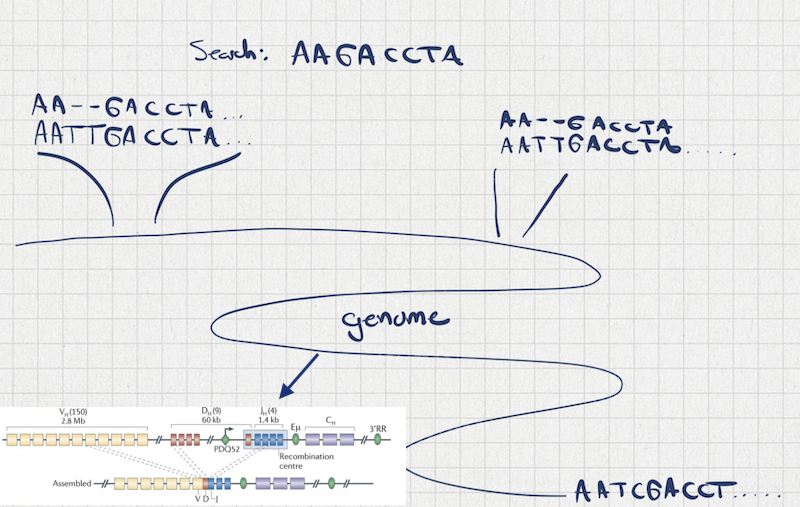

[Schatz and Ji](https://www.nature.com/articles/nri2941)

## There's structure everywhere

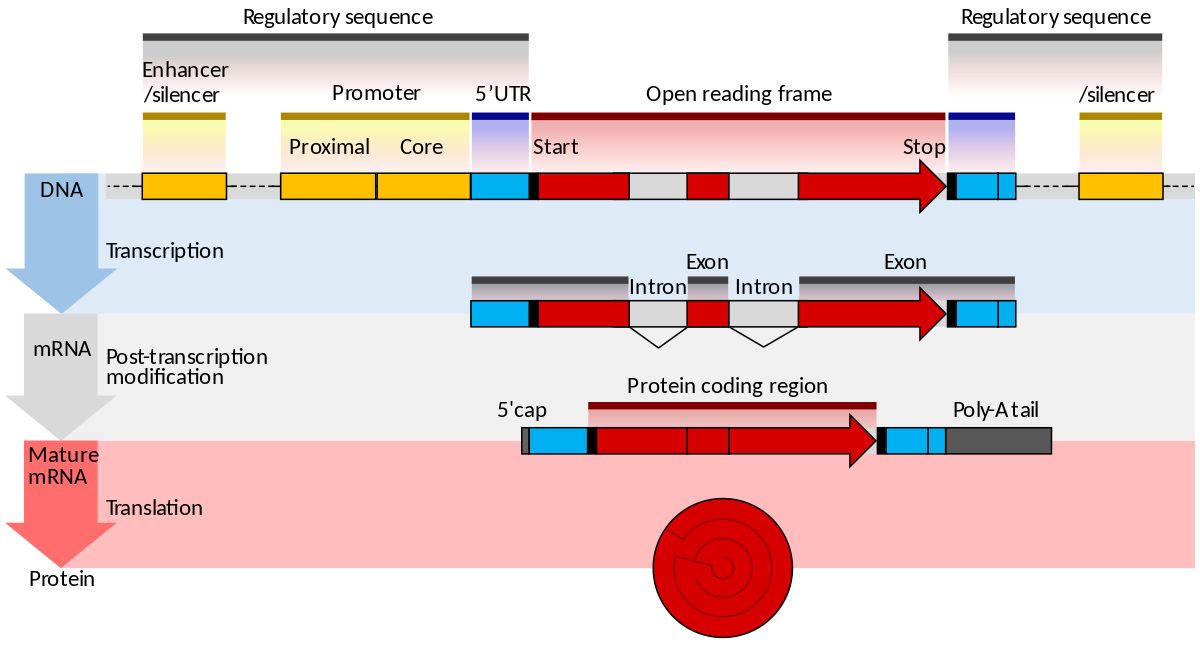

[Wikipedia](https://www.google.com/url?sa=i&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2F5%25E2%2580%25B2_flanking_region&psig=AOvVaw2kOC-4bb8eq7qlRI56yiKq&ust=1621912851351000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCIj1rPGu4fACFQAAAAAdAAAAABAJ)

# CpG islands

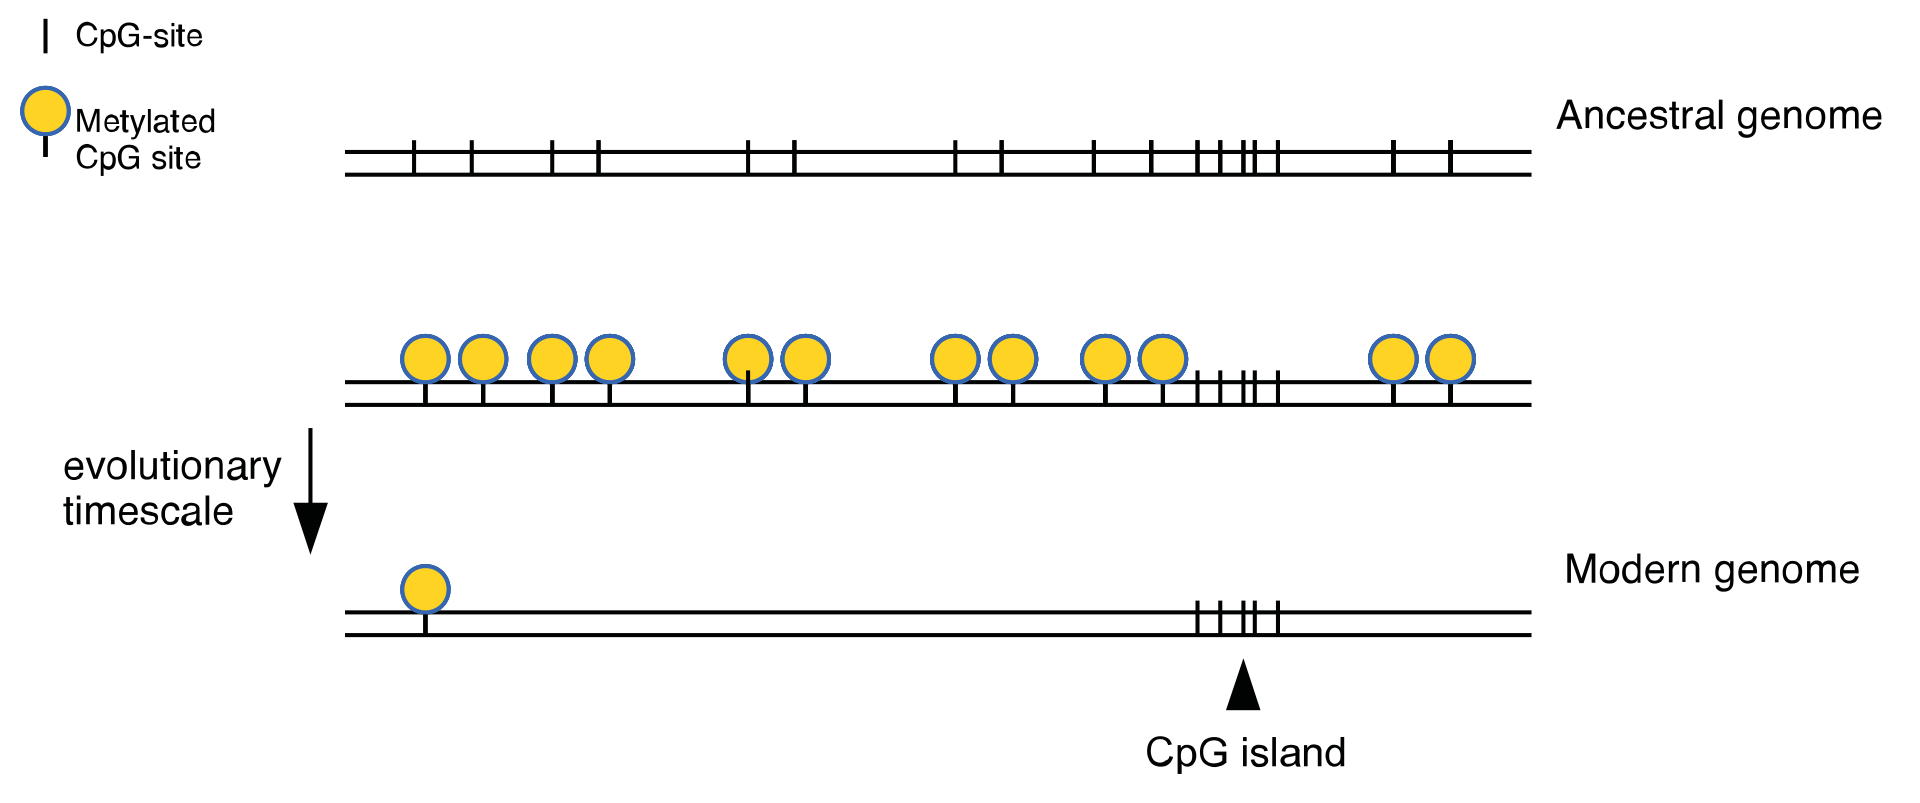

[Wikipedia](https://en.wikipedia.org/wiki/CpG_site#/media/File:Cpg_island_evolution.svg)



## Often the underlying state is what interests us

- We get to see the nucleotides only, but this higher-order states is hidden from our view

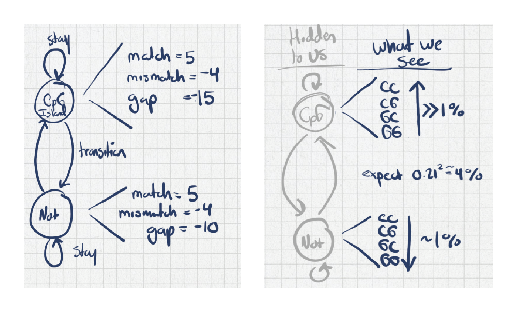

# HHMs 

- Markov process 

- Hidden Markov models provide a way to model these higher-order state transitions, with tools to:

    - Predict regions matching against these underlying states

    - Estimate the emission and transition probabilties directly from the data

    - Are a gateway to many other machine learning methods

- That's all a lot to chew on, let's process a more simple example


# A very contrived but hopefully helpful example

- A simple game; guess heads or tails in a coin flip

- You win, you get a dollar, you lose, you lose a dollar

- In the long run no one wins, so there's a lot of reason to cheat even slightly

- A cheating 'heads-tails' dealer (?) will swap in a biased coin from time to time, trying to make money while avoiding being caught

- You're carefully watching this unfold, and see 63 heads in the first 100 tosses. You watched carefully so there's no coin swap. You've heard of a 75% heads coin, and you want to estimate which coin would be more likely, fair or biased.

- How would you know?



## Comparing the two models

Fair coin probability of 63 heads:

$ P(x|F) = \prod_{i=1} P_F(x) = (1/2)^k * (1/2)^{n - k} = (1/2)^n$

Biased coin:

$ P(x|F) = \prod_{i=1} P_F(x) = (3/4)^k * (1/4)^{n - k} = \frac{3^{k}}{4^n}$

As $n$ gets really large, these probabilities get really small. Moreover we want to know the relative odds in this case, which we'll use the log odds to determine:

$log_2{ \frac{P(x|f)}{P(x|B)}} = log_2{\frac{2^n}{3^k}} = n - k * log_2{ 3}$

In [28]:
import math
print(100 - (63 * math.log2(3)))

print(math.pow(0.5,63) * math.pow(0.5,37))
print(math.pow(0.75,63) * math.pow(0.25,37))

0.14736245456717256
7.888609052210118e-31
7.122622291008305e-31


## Now if we allow transitions in addition to emissions

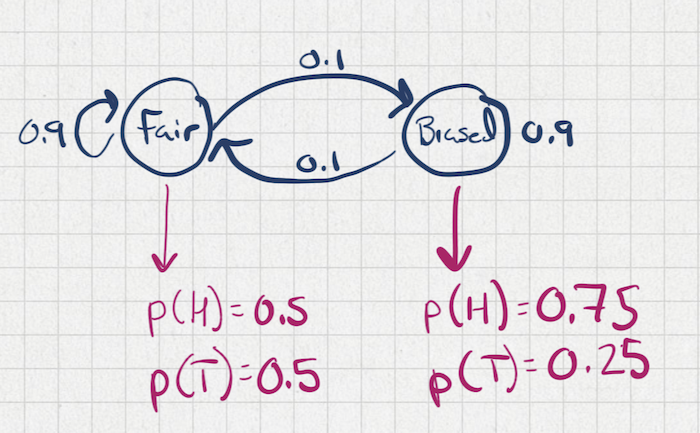

We'll work on building an HMM model for CpG prediction next time. We're interested in generally how to estimate the probability of $p(x,e) = p(x|e) * p(e)$ the joint probability of state and emission over all possible states and emissions. It's a big adventure

## Logistics again

- Homework 5 due Wednesday

- Homework 4 is being graded

- Homework 6, our last homework, will be out on Wednesday. Due Monday.

- Next time: coins to CpGs, conditional prob., dynamic programming for HMMs, and more!